# **Model Building and Testing**

---

## **Import necessary libraries**

In [4]:
# basic libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# preprocessing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# model libraries
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# evaluation libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# other libraries
import mysql.connector as mysql
import warnings
from dotenv import load_dotenv
warnings.filterwarnings('ignore')


load_dotenv()

True

### Connect with the database

In [5]:
# connect to the database
db = mysql.connect(
    host = os.getenv('host'),
    user = os.getenv('user'),
    port = os.getenv('port'),
    passwd = os.getenv('password'),
    database = os.getenv('database')
)

### Load the data in a dataframe

In [7]:
# read the data from the database into a pandas dataframe
df = pd.read_sql("SELECT * FROM laptop", con=db)

### Extract features and target column

In [8]:
X = df.drop(columns=['Price_euros', 'laptop_ID'], axis=1)
y = df['Price_euros']

### Feature Engineering

In [9]:
num_cols = X.select_dtypes(include=np.number).columns
cat_cols = X.select_dtypes(include='object').columns

num_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
         ('scaler', StandardScaler())
    ]
)

cat_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder(handle_unknown = 'error')),
        ('scaler', StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    [
        ('num_pipeline', num_pipeline, num_cols),
        ('cat_pipeline', cat_pipeline, cat_cols)
    ]
)

In [10]:
X = preprocessor.fit_transform(X)


### Model building

In [12]:
models = {
    'LinearRegression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'RandomForestRegressor': RandomForestRegressor(),
    'AdaBoostRegressor': AdaBoostRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'SVR': SVR(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'XGBRegressor': XGBRegressor()
}

In [14]:
# split the feature and target column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [15]:
def eval_model(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, r2

### Model Evaluation

In [16]:
for i in range(len(models)):
    model = list(models.values())[i]
    model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate Train and Test dataset
    model_train_mae, model_train_mse, model_train_r2 = eval_model(y_train, y_train_pred)

    model_test_mae, model_test_mse, model_test_r2 = eval_model(y_test, y_test_pred)

    print(list(models.keys())[i])
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_mse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')

    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_mse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    print('='*35)
    print('\n')



LinearRegression
Model performance for Training set
- Root Mean Squared Error: 244676.7212
- Mean Absolute Error: 369.5365
- R2 Score: 0.4936
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 306598.7169
- Mean Absolute Error: 377.0740
- R2 Score: 0.3964


Lasso
Model performance for Training set
- Root Mean Squared Error: 244699.2193
- Mean Absolute Error: 369.3590
- R2 Score: 0.4936
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 306414.6392
- Mean Absolute Error: 376.7542
- R2 Score: 0.3967


Ridge
Model performance for Training set
- Root Mean Squared Error: 244676.9560
- Mean Absolute Error: 369.5183
- R2 Score: 0.4936
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 306576.5531
- Mean Absolute Error: 377.0462
- R2 Score: 0.3964


RandomForestRegressor
Model performance for Training set
- Root Mean Squared Error: 11279.7552
- Mean Absolute Error: 63.7

### Tuning the generalized model

In [17]:
# lets tune GradientBoostingRegressor

model = GradientBoostingRegressor()

params = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 4, 5, 6]
}

grid_search = GridSearchCV(model, param_grid=params, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [3, 4, 5, 6],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='neg_mean_squared_error')

In [18]:
# get the best paams
best_params = grid_search.best_params_
best_params

{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 400}

In [19]:
model = GradientBoostingRegressor(learning_rate=best_params['learning_rate'], n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'])

model.fit(X_train, y_train)


In [26]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [28]:
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

# print the model accuracy
print('Model performance for Train set')
print("- R2 Score: {:.4f}".format(r2_train))
print('='*35)
print('\n')

print('Model performance for Test set')
print("- R2 Score: {:.4f}".format(r2_test))
print('='*35)

Model performance for Train set
- R2 Score: 0.9776


Model performance for Test set
- R2 Score: 0.8950


---

### Visualizing the feature importance

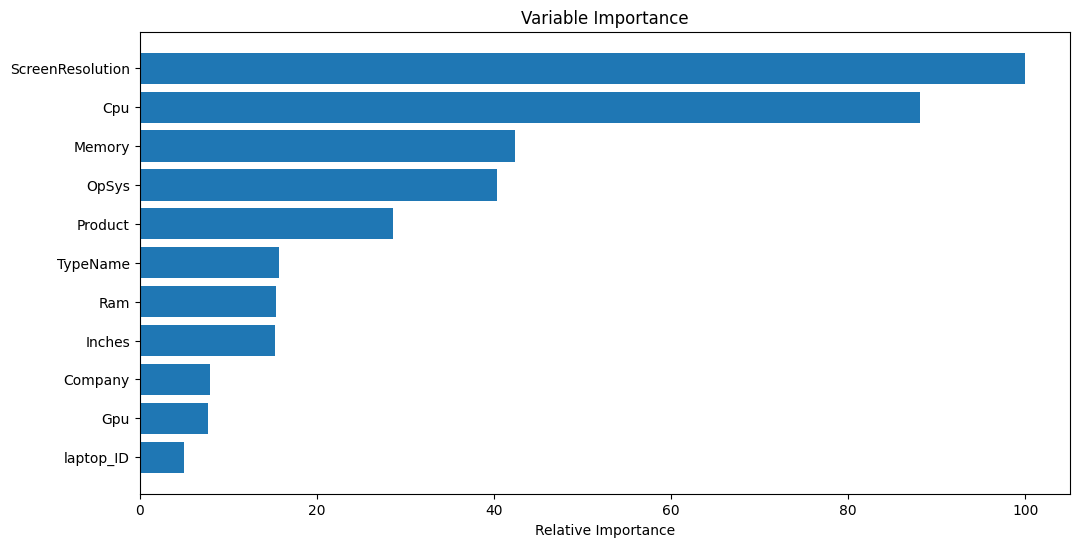

In [34]:
# lets print the feature importance
feature_importance = model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(df.columns)[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()